In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
#from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table
import emcee
import stella

### Using Stella to identify flares on tic 272232401 which is an M3 star
http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=tic272232401&submit=SIMBAD+search

http://adina.feinste.in/stella/getting_started/shortest_demo.html#1.2-Using-the-Models

In [2]:
import os, sys
#sys.path.insert(1, '/Users/arcticfox/Documents/GitHub/stella/')
#/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/stella/
from tqdm import tqdm_notebook

In [3]:
#sys.path

In [4]:
ds = stella.DownloadSets()
ds.download_models()

Models have already been downloaded to ~/.stella/models


Initialize the class

In [5]:
OUT_DIR = '/Users/lupitatovar/local_flares/stella/results/s2'

In [6]:
cnn = stella.ConvNN(output_dir=OUT_DIR)

Can only use stella.ConvNN.predict().


### Importing in lightcurve for GJ1243

In [7]:
from lightkurve import search_lightcurve
from lightkurve import search_targetpixelfile
#target = '273589987'
target='tic272232401'
star = search_lightcurve(target,exptime=120,mission='TESS')
star = star.download().PDCSAP_FLUX.normalize()
star = star.remove_nans()
#exptime = 120 also works instead of cadence = 'short'


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/lightkurve/search.py:352: LightkurveWarning: Warning: 16 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning,
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  


<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

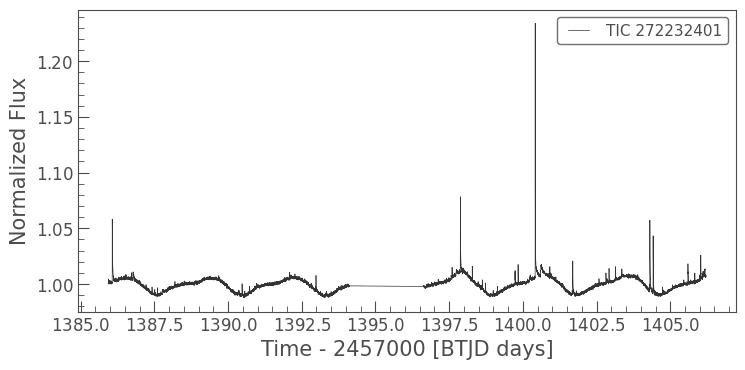

In [8]:

star.plot()

In [9]:
star.time.btjd

array([1385.93534062, 1385.93672949, 1385.93811835, ..., 1406.20999205,
       1406.21138092, 1406.21276979])

In [10]:
cnn.predict(modelname=ds.models[0],
            times=star.time.btjd,
            fluxes=star.flux,
            errs=star.flux_err)
single_pred = cnn.predictions[0]

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


In [11]:
cnn.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 200, 16)           64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 16)           0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 64)           3136      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0

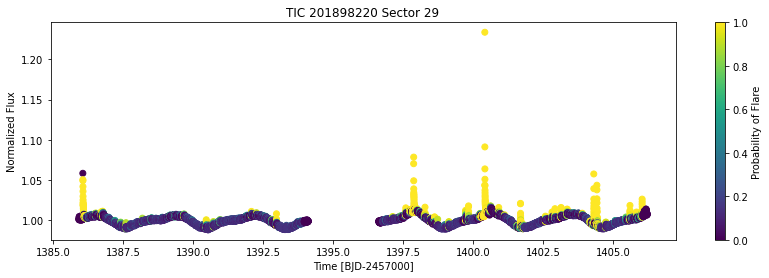

In [12]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=single_pred, vmin=0, vmax=1)
plt.colorbar(label='Probability of Flare')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
plt.title('TIC 201898220 Sector 29');

In [13]:
#ensembling
preds = np.zeros((len(ds.models),len(cnn.predictions[0])))

for i, model in enumerate(ds.models):
    cnn.predict(modelname=ds.models[0],
                times=star.time.btjd,
                fluxes=star.flux,
                errs=star.flux_err)
    preds[i] = cnn.predictions[0]

avg_pred = np.nanmedian(preds, axis=0)

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


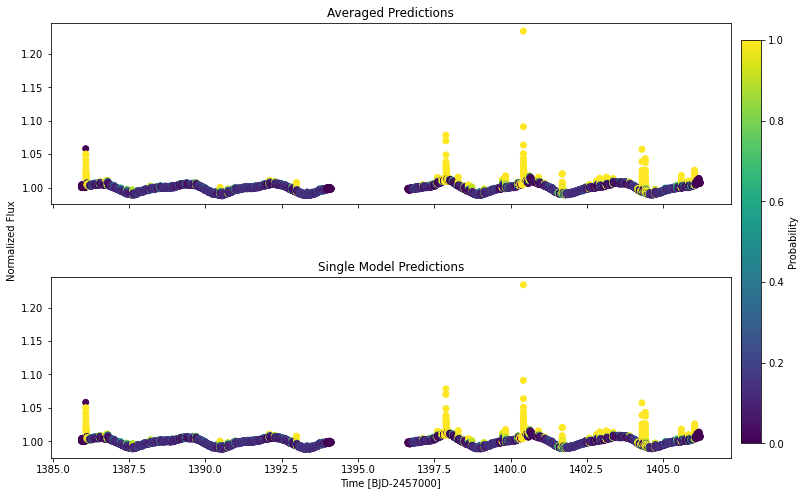

In [14]:
fig, (ax1, ax2) = plt.subplots(figsize=(14,8), nrows=2,
                               sharex=True, sharey=True)
im = ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1)
ax2.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=single_pred, vmin=0, vmax=1)
ax2.set_xlabel('Time [BJD-2457000]')
ax2.set_ylabel('Normalized Flux', y=1.2)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Probability')


ax1.set_title('Averaged Predictions')
ax2.set_title('Single Model Predictions')

plt.subplots_adjust(hspace=0.4);

Text(0.5, 1.0, 'Black = Single Model; Orange = Averaged Models')

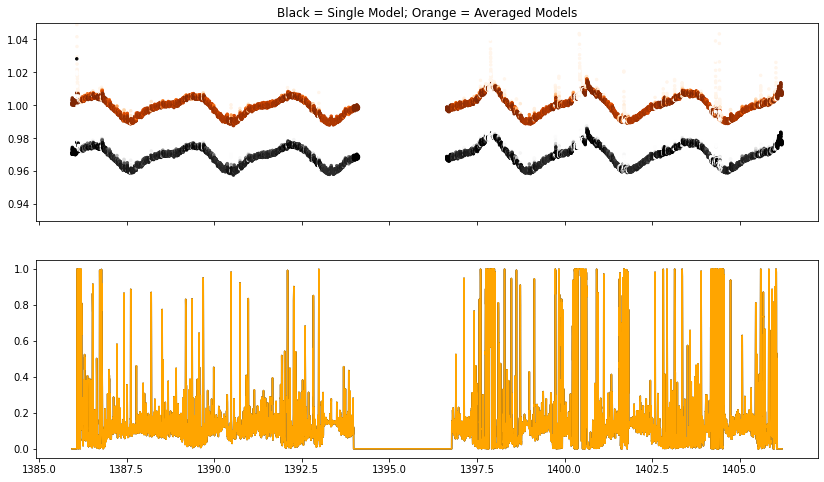

In [15]:
#zooming in to see differences
fig, (ax1, ax2) = plt.subplots(figsize=(14,8), nrows=2,
                               sharex=True)
ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1, cmap='Oranges_r', s=6)
ax1.scatter(cnn.predict_time[0], cnn.predict_flux[0]-0.03,
            c=single_pred, vmin=0, vmax=1, cmap='Greys_r', s=6)
ax1.set_ylim(0.93,1.05)
ax2.plot(cnn.predict_time[0], single_pred, 'k')
ax2.plot(cnn.predict_time[0], avg_pred, 'orange')
ax1.set_title('Black = Single Model; Orange = Averaged Models')

#plt.xlim(1699,1705)
#plt.xlim(1733,1735)

### Measuring Rotation Period : http://adina.feinste.in/stella/getting_started/other_features.html


In [16]:
mProt = stella.MeasureProt([target], [star.time.btjd], [star.flux], [star.flux_err])

In [17]:
mProt.run_LS()

Finding most likely periods: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


In [18]:
mProt.LS_results

Target_ID,period_days,secondary_period_days,gauss_width,max_power,secondary_max_power,orbit_flag,oflag1,oflag2,Flags,avg_period_days
str12,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
tic272232401,2.822608818261771,2.8264071956863135,0.35331518081337143,0.7890531965687598,0.12773428597856737,0.0,0.0,0.0,0,2.822608818261771


<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

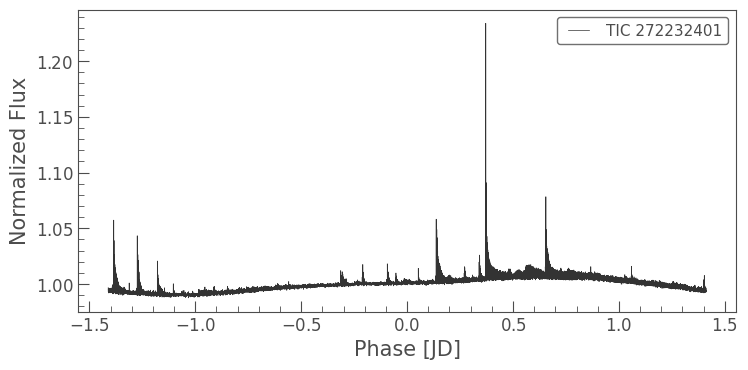

In [19]:
star.fold(mProt.LS_results['avg_period_days'].data[0]).plot()

### Fitting Flares with Stella

In [20]:
MODEL_DIR = '/Users/lupitatovar/.stella/models'
MODEL = [os.path.join(MODEL_DIR,i) for i in
          os.listdir(MODEL_DIR) if i.endswith('.h5')][0]

In [21]:
star.targetid

272232401

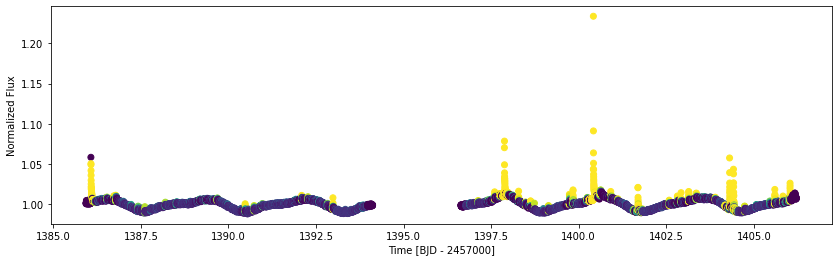

In [22]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0], c=cnn.predictions[0], vmin=0, vmax=1)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Normalized Flux');

In [23]:
# fitting the flares
ff = stella.FitFlares(id=[star.targetid],
                      time=[star.time.btjd],
                      flux=[star.flux.value],
                      flux_err=[star.flux_err.value],
                      predictions=[cnn.predictions[0]])


In [24]:
cnn.predictions[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [25]:
ff.identify_flare_peaks(threshold=0.9)

ff.flare_table

Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(results)
Finding & Fitting Flares: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Target_ID,tpeak,amp,ed_s,rise,fall,prob
float64,float64,float64,float64,float64,float64,float64
272232401.0,1386.5339408073837,1.0025378875561597,1.3052606300178609,0.0001,0.005691084941540489,0.909392774105072
272232401.0,1386.778380811757,1.0044514634371136,3.6056986355485625,0.0001,0.01,0.9973745346069336
272232401.0,1386.778380811757,1.0044514634371136,3.6056986355485625,0.0001,0.01,0.9973745346069336
272232401.0,1386.778380811757,1.0044514634371136,3.6056986355485625,0.0001,0.01,0.9973745346069336
272232401.0,1390.4769254140515,1.0098874711700423,3.9538460892980773,0.0001,0.003858494492725968,0.9812335968017578
272232401.0,1390.7324763704516,1.0057255139619647,3.6722859589910395,0.0001,0.006981194801349517,0.9235396385192871
272232401.0,1392.0907850777858,1.0048040817093413,3.78936979738524,0.0001,0.01,0.9934818744659424
272232401.0,1392.2699484617956,1.0036037711185513,1.3418658557200749,0.0001,0.0012611244612707672,0.9032164812088013
272232401.0,1392.9838241440552,1.0126879635918162,3.449243201275354,0.0001,0.002455538408166492,0.9992833137512207


In [26]:
flare = [ff.flare_table[ff.flare_table['prob'] == 1.0]]
gt_5=[ff.flare_table[ff.flare_table['prob'] >= 0.5]]
print((flare))
print(len(gt_5))
#19 instances where probability of a flare = 1 
#28 instances where probablitiy is gt 5

[<Table length=21>
 Target_ID        tpeak        ...         fall           prob 
  float64        float64       ...       float64        float64
----------- ------------------ ... -------------------- -------
272232401.0 1397.8809498423448 ... 0.005203824148573997     1.0
272232401.0 1397.8809498423448 ... 0.005203824148573997     1.0
272232401.0 1397.8809498423448 ... 0.005203824148573997     1.0
272232401.0 1400.4197988385997 ...  0.00199483127297521     1.0
272232401.0 1400.4197988385997 ...  0.00199483127297521     1.0
272232401.0 1401.6933909683125 ... 0.004064118536209507     1.0
272232401.0 1401.6933909683125 ... 0.004064118536209507     1.0
272232401.0 1401.6933909683125 ... 0.004064118536209507     1.0
272232401.0 1404.3086306826415 ... 0.005455118491922304     1.0
272232401.0 1404.3086306826415 ... 0.005455118491922304     1.0
272232401.0 1404.3086306826415 ... 0.005455118491922304     1.0
272232401.0 1404.3086306826415 ... 0.005455118491922304     1.0
272232401.0 1404.3086

In [27]:
print(cnn.predictions[0])

[0. 0. 0. ... 0. 0. 0.]


Marking the flares

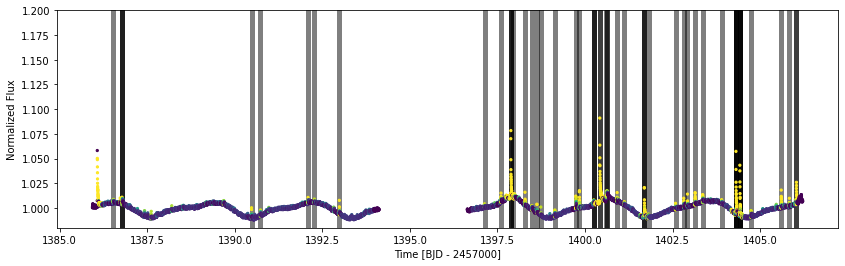

In [28]:
plt.figure(figsize=(14,4))
plt.scatter(ff.time[0], ff.flux[0],c=cnn.predictions[0], s=5)

for tpeak in ff.flare_table['tpeak']:
    plt.vlines(tpeak, 0,2, color='k', alpha=0.5, linewidth=5, zorder=0)

plt.ylim(0.98,1.2)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Normalized Flux');
#plt.xlim(2088,2113)
#plt.ylim(0.99,1.02)

## FFD

In [29]:
from astropy.modeling.models import Gaussian2D


def FFD(ED, TOTEXP=1., Lum=30., fluxerr=0., dur=[], logY=True, est_comp=False):
    '''
    Given a set of stellar flares, with accompanying durations light curve properties,
    compute the reverse cumulative Flare Frequency Distribution (FFD), and
    approximate uncertainties in both energy and rate (X,Y) dimensions.
    This diagram can be read as measuring the number of flares per day at a
    given energy or larger.
    Not a complicated task, just tedious.
    Y-errors (rate) are computed using Poisson upper-limit approximation from
    Gehrels (1986) "Confidence limits for small numbers of events in astrophysical data", https://doi.org/10.1086/164079
    Eqn 7, assuming S=1.
    X-errors (event energy) are computed following Signal-to-Noise approach commonly
    used for Equivalent Widths in spectroscopy, from
    Vollmann & Eversberg (2006) "Astronomische Nachrichten, Vol.327, Issue 9, p.862", https://dx.doi.org/10.1002/asna.200610645
    Eqn 6.
    Parameters
    ----------
    ED : array of Equiv Dur's, need to include a luminosity!
    TOTEXP : total duration of observations, in days
    Lum : the log luminosity of the star
    fluxerr : the average flux errors of your data (in relative flux units!)
    dur : array of flare durations.
    logY : if True return Y-axis (and error) in log rate (Default: True)
    est_comp : estimate incompleteness using histogram method, scale Y errors?
        (Default: True)
    Returns
    -------
    ffd_x, ffd_y, ffd_xerr, ffd_yerr
    X coordinate always assumed to be log_10(Energy)
    Y coordinate is log_10(N/Day) by default, but optionally is N/Day
    Upgrade Ideas
    -------------
    - More graceful behavior if only an array of flares and a total duration are
        specified (i.e. just enough to make ffd_x, ffd_y)
    - Better propogation of specific flux errors in the light curve, rather than
        average error used
    - Include detrending errors? (e.g. from a GP)
    - Asymmetric Poisson errors?
    - Better handling of incompleteness?
    '''
    # REVERSE sort the flares in energy
    ss = np.argsort(np.array(ED))[::-1]
    ffd_x = np.log10(ED[ss]) + Lum

    Num = np.arange(1, len(ffd_x)+1)
    ffd_y = Num / TOTEXP

    # approximate the Poisson Y errors using Gehrels (1986) eqn 7
    Perror = np.sqrt(Num + 0.75) + 1.0
    ffd_yerr = Perror / TOTEXP

    # estimate completeness using the cumulative distribution of the histogram
    if est_comp:
        # make very loose guess at how many bins to choose
        nbin = int(np.sqrt(len(ffd_x)))
        if nbin < 10:
            nbin=10 # but use at least 10 bins

        # make histogram of the log(energies)
        hh, be = np.histogram(ffd_x, bins=nbin, range=[np.nanmin(ffd_x), np.nanmax(ffd_x)])
        hh = hh/np.nanmax(hh)
        # make cumulative distribution of the histogram, scale to =1 at the hist peak
        cc = np.cumsum(hh)/np.sum(hh[0:np.argmax(hh)])
        be = (be[1:]+be[0:-1])/2
        # make completeness = 1 for energies above the histogram peak
        cc[np.argmax(hh):] = 1
        # interpolate the cumulative histogram curve back to the original energies
        ycomp = np.interp(ffd_x, be, cc)
        # scale the y-errors by the completeness factor (i.e. inflate small energy errors)
        ffd_yerr = ffd_yerr / ycomp

    if logY:
        # transform FFD Y and Y Error into log10
        ffd_yerr = np.abs(ffd_yerr / np.log(10.) / ffd_y)
        ffd_y = np.log10(ffd_y)

    # compute X uncertainties for FFD
    if len(dur)==len(ffd_x):

        # assume relative flux error = 1/SN
        S2N = 1/fluxerr
        # based on Equivalent Width error
        # Eqn 6, Vollmann & Eversberg (2006) Astronomische Nachrichten, Vol.327, Issue 9, p.862
        ED_err = np.sqrt(2)*(dur[ss]*86400. - ED[ss])/S2N
        ffd_xerr = np.abs((ED_err) / np.log(10.) / ED[ss]) # convert to log
    else:
        # not particularly meaningful, but an interesting shape. NOT reccomended
        print('Warning: Durations not set. Making bad assumptions about the FFD X Error!')

        ffd_xerr = (1/np.sqrt(ffd_x-np.nanmin(ffd_x))/(np.nanmax(ffd_x)-np.nanmin(ffd_x)))
    return ffd_x, ffd_y, ffd_xerr, ffd_yerr


def FlareKernel(x, y, xe, ye, Nx=100, Ny=100, xlim=[], ylim=[], return_axis=True):
    '''
    Use 2D Gaussians (from astropy models) to make a basic kernel density,
    with errors in both X and Y considered. Turn into a 2D "image"
    Upgrade Ideas
    -------------
    It's slow. Since Gaussians are defined analytically, maybe this could be
    re-cast as a single array math opperation, and then refactored to have the
    same fit/evaluate behavior as KDE functions.  Hmm...
    '''

    if len(xlim) == 0:
        xlim = [np.nanmin(x) - np.nanmean(xe), np.nanmax(x) + np.nanmean(xe)]
    if len(ylim) == 0:
        ylim = [np.nanmin(y) - np.nanmean(ye), np.nanmax(y) + np.nanmean(ye)]

    xx,yy = np.meshgrid(np.linspace(xlim[0], xlim[1], Nx),
                        np.linspace(ylim[0], ylim[1], Ny), indexing='xy')
    dx = (np.max(xlim)-np.min(xlim)) / (Nx-1)
    dy = (np.max(ylim)-np.min(ylim)) / (Ny-1)

    im = np.zeros_like(xx)

    for k in range(len(x)):
        g = Gaussian2D(amplitude=1/(2*np.pi*(xe[k]+dx)*(ye[k]+dy)),
                       x_mean=x[k], y_mean=y[k], x_stddev=xe[k]+dx, y_stddev=ye[k]+dy)
        tmp = g(xx,yy)
        if np.isfinite(np.sum(tmp)):
            im = im + tmp

    if return_axis:
        return im, xx, yy
    else:
        return im

In [30]:
flare_table = ff.flare_table
flare_table

Target_ID,tpeak,amp,ed_s,rise,fall,prob
float64,float64,float64,float64,float64,float64,float64
272232401.0,1386.5339408073837,1.0025378875561597,1.3052606300178609,0.0001,0.005691084941540489,0.909392774105072
272232401.0,1386.778380811757,1.0044514634371136,3.6056986355485625,0.0001,0.01,0.9973745346069336
272232401.0,1386.778380811757,1.0044514634371136,3.6056986355485625,0.0001,0.01,0.9973745346069336
272232401.0,1386.778380811757,1.0044514634371136,3.6056986355485625,0.0001,0.01,0.9973745346069336
272232401.0,1390.4769254140515,1.0098874711700423,3.9538460892980773,0.0001,0.003858494492725968,0.9812335968017578
272232401.0,1390.7324763704516,1.0057255139619647,3.6722859589910395,0.0001,0.006981194801349517,0.9235396385192871
272232401.0,1392.0907850777858,1.0048040817093413,3.78936979738524,0.0001,0.01,0.9934818744659424
272232401.0,1392.2699484617956,1.0036037711185513,1.3418658557200749,0.0001,0.0012611244612707672,0.9032164812088013
272232401.0,1392.9838241440552,1.0126879635918162,3.449243201275354,0.0001,0.002455538408166492,0.9992833137512207


In [36]:
flare_table=flare_table.to_pandas()


In [38]:
flare_table = flare_table.drop_duplicates()

In [39]:
flare_table

,Target_ID,tpeak,amp,ed_s,rise,fall,prob
0,272232401.0,1386.533941,1.002538,1.305261,0.0001,0.005691,0.909393
1,272232401.0,1386.778381,1.004451,3.605699,0.0001,0.010000,0.997375
4,272232401.0,1390.476925,1.009887,3.953846,0.0001,0.003858,0.981234
5,272232401.0,1390.732476,1.005726,3.672286,0.0001,0.006981,0.923540
6,272232401.0,1392.090785,1.004804,3.789370,0.0001,0.010000,0.993482
7,272232401.0,1392.269948,1.003604,1.341866,0.0001,0.001261,0.903216
8,272232401.0,1392.983824,1.012688,3.449243,0.0001,0.002456,0.999283
9,272232401.0,1397.129574,1.003621,1.249096,0.0001,0.003197,0.949593
10,272232401.0,1397.600399,1.008952,6.532505,0.0001,0.008953,0.999956
11,272232401.0,1397.880950,1.064443,30.643657,0.0001,0.005204,1.000000


In [31]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans - serif"
rcParams["font.sans-serif"] = ["Verdana"]
rcParams["text.usetex"] = True


In [42]:
exp = (np.nanmedian(np.diff(star.time.bkjd))) * (len(star.time.bkjd))
print(exp)

17.53302787454595


Note we need flare start and stope time so that we can define the duration variable fed in to create the ffd, otherwise we are also make bad assumptions about the FFD x error

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: divide by zero encountered in true_divide
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/numpy/core/function_base.py:144: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/numpy/core/function_base.py:154: RuntimeWarning: invalid value encountered in add
  y += start
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/astropy/modeling/utils.py:669: RuntimeWarning: invalid value encountered in double_scalars
  t = np.arctan2(b, a * np.tan(theta))
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/astropy/modeling/functional_models.py:380: RuntimeWarning: invalid value encountered in multiply
  return amplitude * np.exp(-((a * xdiff ** 2) + (b * xdiff * ydiff) +


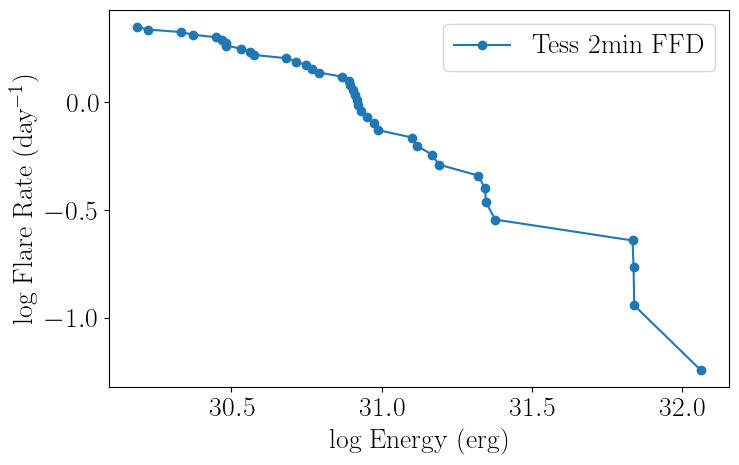

In [44]:
x,y,xe,ye = FFD(flare_table['ed_s'].values, Lum=30.352907,TOTEXP=exp,
                fluxerr=np.median(star.flux_err.value)/np.median(star.flux.value))

im, xx, yy = FlareKernel(x,y,xe,ye)
plt.plot(x,y,'-o',label='Tess 2min FFD') #Jim's ffd code


#plt.errorbar(x,y, xerr=xe, yerr=ye)
#plt.contour(xx, yy, im)
plt.xlabel('log Energy (erg)')
plt.ylabel('log Flare Rate (day$^{-1}$)')
plt.legend()
#plt.ylim(-1.5,0.5)
#plt.xlim(29.5,33.5)

Since stella is trained on the 2min data and overpredicts the amount of flares in the 20s data I cross-match tpeak found in the 2 minute data to the 20 second data and then fit a flare model in the 20 second data. 

In [ ]:
star_20s = search_lightcurve(target,exptime=20,mission='TESS').download_all()

In [ ]:
star_20s

In [ ]:
s29_20s = star_20s[0].PDCSAP_FLUX.remove_nans()

In [ ]:
s29_20s.scatter()

Trying out stella on 20s data as proof of concept

In [ ]:
cnn2 = stella.ConvNN(output_dir=OUT_DIR)
cnn2.predict(modelname=ds.models[0],
            times=s29_20s.time.btjd,
            fluxes=s29_20s.flux,
            errs=s29_20s.flux_err)
single_pred2 = cnn2.predictions[0]

In [ ]:
plt.figure(figsize=(14,4))
plt.scatter(cnn2.predict_time[0], cnn2.predict_flux[0],
            c=single_pred2, vmin=0, vmax=1)
plt.colorbar(label='Probability of Flare')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
plt.title('TIC 201898220 Sector 29 20s data');

In [ ]:
#ensembling
preds2 = np.zeros((len(ds.models),len(cnn2.predictions[0])))

for i, model in enumerate(ds.models):
    cnn2.predict(modelname=ds.models[0],
                times=s29_20s.time.btjd,
                fluxes=s29_20s.flux,
                errs=s29_20s.flux_err)
    preds2[i] = cnn2.predictions[0]

avg_pred2 = np.nanmedian(preds2, axis=0)

In [ ]:
#zooming in to see differences
fig, (ax1, ax2) = plt.subplots(figsize=(14,8), nrows=2,
                               sharex=True)
ax1.scatter(cnn2.predict_time[0], cnn2.predict_flux[0],
            c=avg_pred2, vmin=0, vmax=1, cmap='Oranges_r', s=6)
ax1.scatter(cnn2.predict_time[0], cnn2.predict_flux[0]-0.03,
            c=single_pred2, vmin=0, vmax=1, cmap='Greys_r', s=6)
ax1.set_ylim(0.93,1.05)
ax2.plot(cnn2.predict_time[0], single_pred2, 'k')
ax2.plot(cnn2.predict_time[0], avg_pred2, 'orange')
ax1.set_title('Black = Single Model; Orange = Averaged Models')

#plt.xlim(1699,1705)
#plt.xlim(1733,1735)

In [ ]:
print(len(s29_20s.flux.value))
print(len(flat_lc.flux.value)) #2min data
print(len(s29_20s.time.btjd))
print(len(s29_20s.flux_err.value))

In [ ]:
# fitting the flares
ff_20s = stella.FitFlares(id=[s29_20s.targetid],
                      time=[s29_20s.time.btjd],
                      flux=[s29_20s.flux.value],
                      flux_err=[s29_20s.flux_err.value],
                      predictions=[cnn2.predictions[0]])

In [ ]:
ff_20s.identify_flare_peaks(threshold=0.75)

ff_20s.flare_table